In [1]:
# load and autoreload
from IPython import get_ipython
# noinspection PyBroadException
try:
    _magic = get_ipython().magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass
    

import os 
import glob
import sys
import pprint
import datetime as dt
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt 
import xarray as xr 
import seaborn as sns
import cartopy as crt

In [2]:
f = './data/south.america.subnational.mortality.txt'

In [3]:
df = pd.read_csv(f)

In [4]:
IC,CN,AI,AN,FR,DT,DE = ('iso_code', 'country_name', 'adm1_isocode', 'adm1_name', 'frequency',
       'date', 'deaths')

In [5]:
nam = df.drop_duplicates([CN,AN])[[CN,AN,AI]]

In [6]:
con = df.drop_duplicates(CN)[CN]

In [7]:
nam.to_csv('./data/coun_adm.csv')

In [8]:
cdf = pd.read_csv('./data/city_data.csv',na_values='QuantityMagnitude[Missing["NotAvailable"]]')
cdf['Elevation'] = cdf['Elevation']/1000

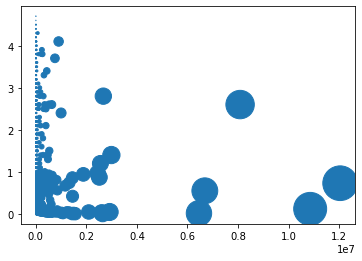

In [9]:
plt.scatter(cdf['Population'],cdf['Elevation'],s=cdf['Population']/10000)

In [10]:
g1= cdf.groupby('AdministrativeDivision')
g= cdf.groupby('Country')

In [11]:
g['Population'].sum()

Country
Bolivia       6480392
Brazil      157831577
Chile        17943835
Colombia     39736325
Ecuador      10688524
Paraguay      4470748
Peru         21902526
Uruguay       3091253
Name: Population, dtype: int64

In [12]:
c1 = cdf[cdf['Elevation'].notna()].copy()
c1['pop_el'] = c1['Population']*c1['Elevation']

In [13]:
g1 = c1.groupby('AdministrativeDivision')

In [14]:
wh = (g1['pop_el'].sum()/g1['Population'].sum())
wh.name = 'weighted_height'
div = wh.to_frame()

In [15]:
div['pop'] = g1['Population'].sum()

In [16]:
from statsmodels.stats.weightstats import DescrStatsW

In [17]:
st = {}
for g,v in g1:
    values = v['Elevation']
    weights = v['Population']
    st[g]=DescrStatsW(values, weights=weights, ddof=1).std
st = pd.Series(st)

In [18]:
div['stw']=st

In [19]:
d1 = div.sort_values('pop',ascending=False)

In [21]:
df['dt']=pd.to_datetime(df['date'])
df1 = df.set_index('dt')

In [22]:
df2=df1.groupby(['adm1_isocode',pd.Grouper(freq='M')]).sum()['deaths'].unstack().T

In [23]:
df3 = df2['2019-01-01':'2019-12-31']

In [24]:
df3.index = df3.index.month

In [25]:
df3.isna().sum().sum()

0

In [26]:
mm = df2['2020-03':'2024']

In [27]:
mm.index = mm.index.month

In [28]:
m2 = mm.sum()/(mm * 0 + df3).sum()

In [29]:
m1 = (mm/df3).mean()

(0.5, 3.0)

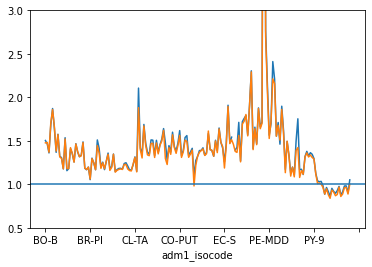

In [30]:
m1.plot()
m2.plot()
ax = plt.gca()
ax.axhline(1)
ax.set_ylim(0.5,3)

In [31]:
adm_dic=pd.read_csv('./data/adm_dic.csv')

In [32]:
m2.name='ratio'
m3 = m2.to_frame()

In [33]:
f1 = pd.merge(m2,adm_dic,left_index=True, right_on='admi',how='inner',
         validate='1:1')

In [34]:
f1

,ratio,mname,pop,country,adm,admi
0,1.477348,"Beni, Bolivia",421196.0,Bolivia,Beni,BO-B
2,1.483096,"Cochabamba, Bolivia",1930143.0,Bolivia,Cochabamba,BO-C
1,1.369958,"Chuquisaca, Bolivia",576153.0,Bolivia,Chuquisaca,BO-H
3,1.705101,"La Paz, Bolivia",2706359.0,Bolivia,La Paz,BO-L
5,1.860465,"Pando, Bolivia",110436.0,Bolivia,Pando,BO-N
...,...,...,...,...,...,...
166,0.888889,"Salto, Uruguay",124878.0,Uruguay,Salto,UY-SA
167,0.962594,"San Jose, Uruguay",108309.0,Uruguay,San Jose,UY-SJ
168,0.964088,"Soriano, Uruguay",82595.0,Uruguay,Soriano,UY-SO
169,0.889441,"Tacuarembo, Uruguay",90053.0,Uruguay,Tacuarembo,UY-TA


In [37]:
Couns = ['Bolivia','Peru','Ecuador','Colombia']

In [38]:
f2 = pd.merge(d1.drop('pop',axis=1),f1,left_index=True,
         right_on='mname',validate='1:1')

f2 = f2.sort_values('pop',ascending=False)
f2 = f2[f2['ratio']<3]
# bo=f2['country']=='Brazil'
# f2 = f2[bo]

cme = f2.groupby('country').median()

f2 = pd.merge(cme,f2,left_on='country',right_on='country',suffixes=['_r',''])
# f2['ratio']=f2['ratio']/f2['ratio_r']

f2 = f2[f2['country'].isin(Couns)]

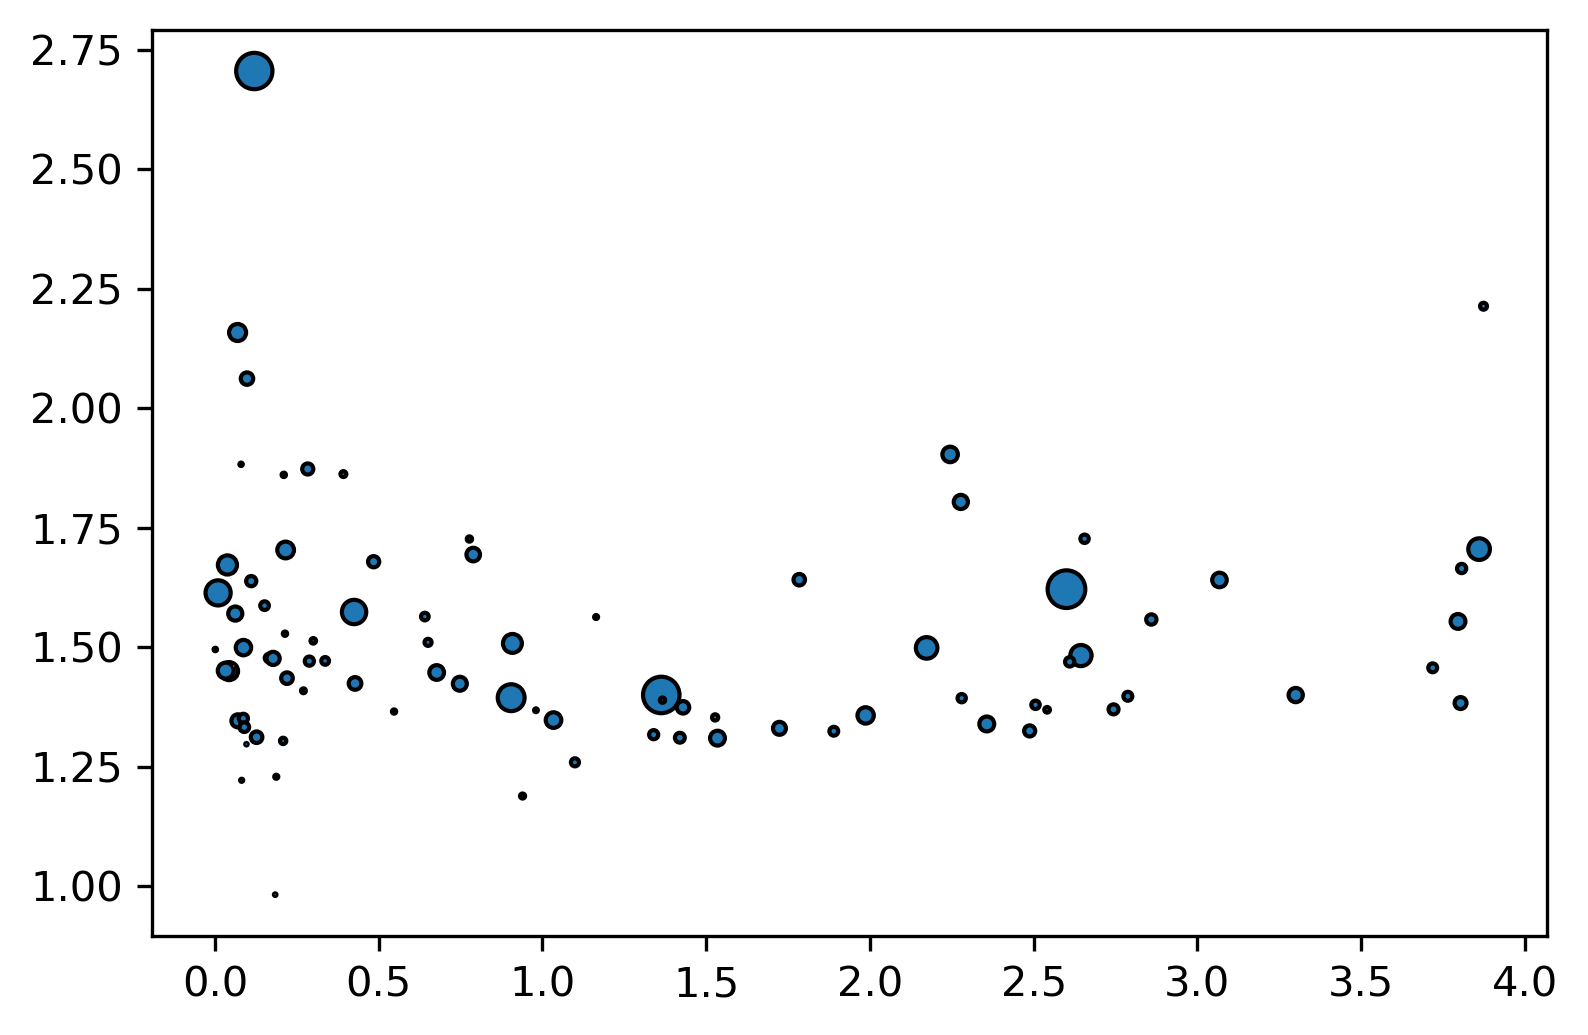

In [39]:
f,ax= plt.subplots(dpi=300)
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors='k'
)
# ax.set_ylim(.5,3)

In [40]:
mea = f2['ratio'].mean()

wmea = (f2['ratio']*f2['pop']).sum()/f2['pop'].sum()

In [41]:
co = f2['country']

In [42]:
dic_ = co.drop_duplicates().reset_index(drop=True).reset_index().set_index('country')['index'].to_dict()

In [43]:
f2['ci']=f2['country'].replace(dic_)

In [44]:
cm = plt.get_cmap('tab10')

In [45]:
cs = [cm(i) for l,i in f2['ci'].items()]

In [46]:
from sklearn.linear_model import QuantileRegressor,LinearRegression

In [47]:
qr = QuantileRegressor(alpha=0)
qr1 = LinearRegression()
qr2 = LinearRegression()

In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
f2_ = f2.sort_values('weighted_height')
X = f2_[['weighted_height']]
y = f2_[['ratio']]

In [50]:
s1 = StandardScaler()
s2 = StandardScaler()

In [51]:
X1 = s1.fit_transform(X)
y1 = s2.fit_transform(y)

In [52]:
qr.fit(X1,y1[:,0])
qr1.fit(X1,y1[:,0])
qr2.fit(X,y.values[:,0])

LinearRegression()

In [53]:
yp11 = qr.predict(X1)
yp12 = qr1.predict(X1)
yp13 = qr2.predict(X)

In [54]:
yp111 = s2.inverse_transform(yp11.reshape(-1,1))[:,0]
yp112 = s2.inverse_transform(yp12.reshape(-1,1))[:,0]

In [56]:
means = {}
wmeans_ = {}
fits = {}
f_xy = {}
for c in dic_.keys():
    boo = f2['country']==c
    means[c]=f2[boo]['ratio'].mean()
    _f = f2[boo].sort_values('weighted_height')
    wm = (_f['ratio'] * _f['pop']).sum()/_f['pop'].sum()
    wmeans_[c]=wm
    
    
    lr = QuantileRegressor(alpha=0)
#     lr = LinearRegression()
    _X = _f[['weighted_height']]
    _y = _f['ratio']
    lr.fit(_X,_y)
    fits[c] = lr
    f_xy[c] = [_X.values[:,0],lr.predict(_X)]
    

In [78]:
means = pd.Series(means).sort_values(ascending=False).to_dict()
dic = {}
wmeans = {}
for i,v in means.items():
    dic[i] = dic_[i]
    wmeans[i] = wmeans_[i]

dic = {'Peru': 6,
 'Bolivia': 0,
 'Ecuador': 4,
 'Colombia': 3,
 }

<AxesSubplot:>

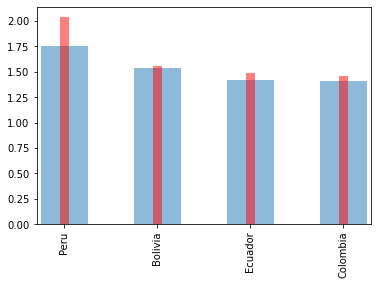

In [79]:
pd.Series(means).plot.bar(alpha=.5)
pd.Series(wmeans).plot.bar(alpha=.5,color='r',width=.1)

In [89]:


doff = {
    'Peru': 0,
     'Bolivia': 0,
     'Ecuador': -.015,
     'Colombia': -.02,
     'Brazil': 0,
     'Paraguay': 0,
     'Chile': 0,
     'Uruguay': 0
}

In [111]:
coef = np.round(np.round(qr2.coef_[0],2)+.000000001,2)

In [116]:
fy = f'$y = {coef:.2f}x + {qr2.intercept_:.2f}$'

In [117]:
f2['ci']=f2['country'].replace(dic)
cs = [cm(i) for l,i in f2['ci'].items()]

In [118]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

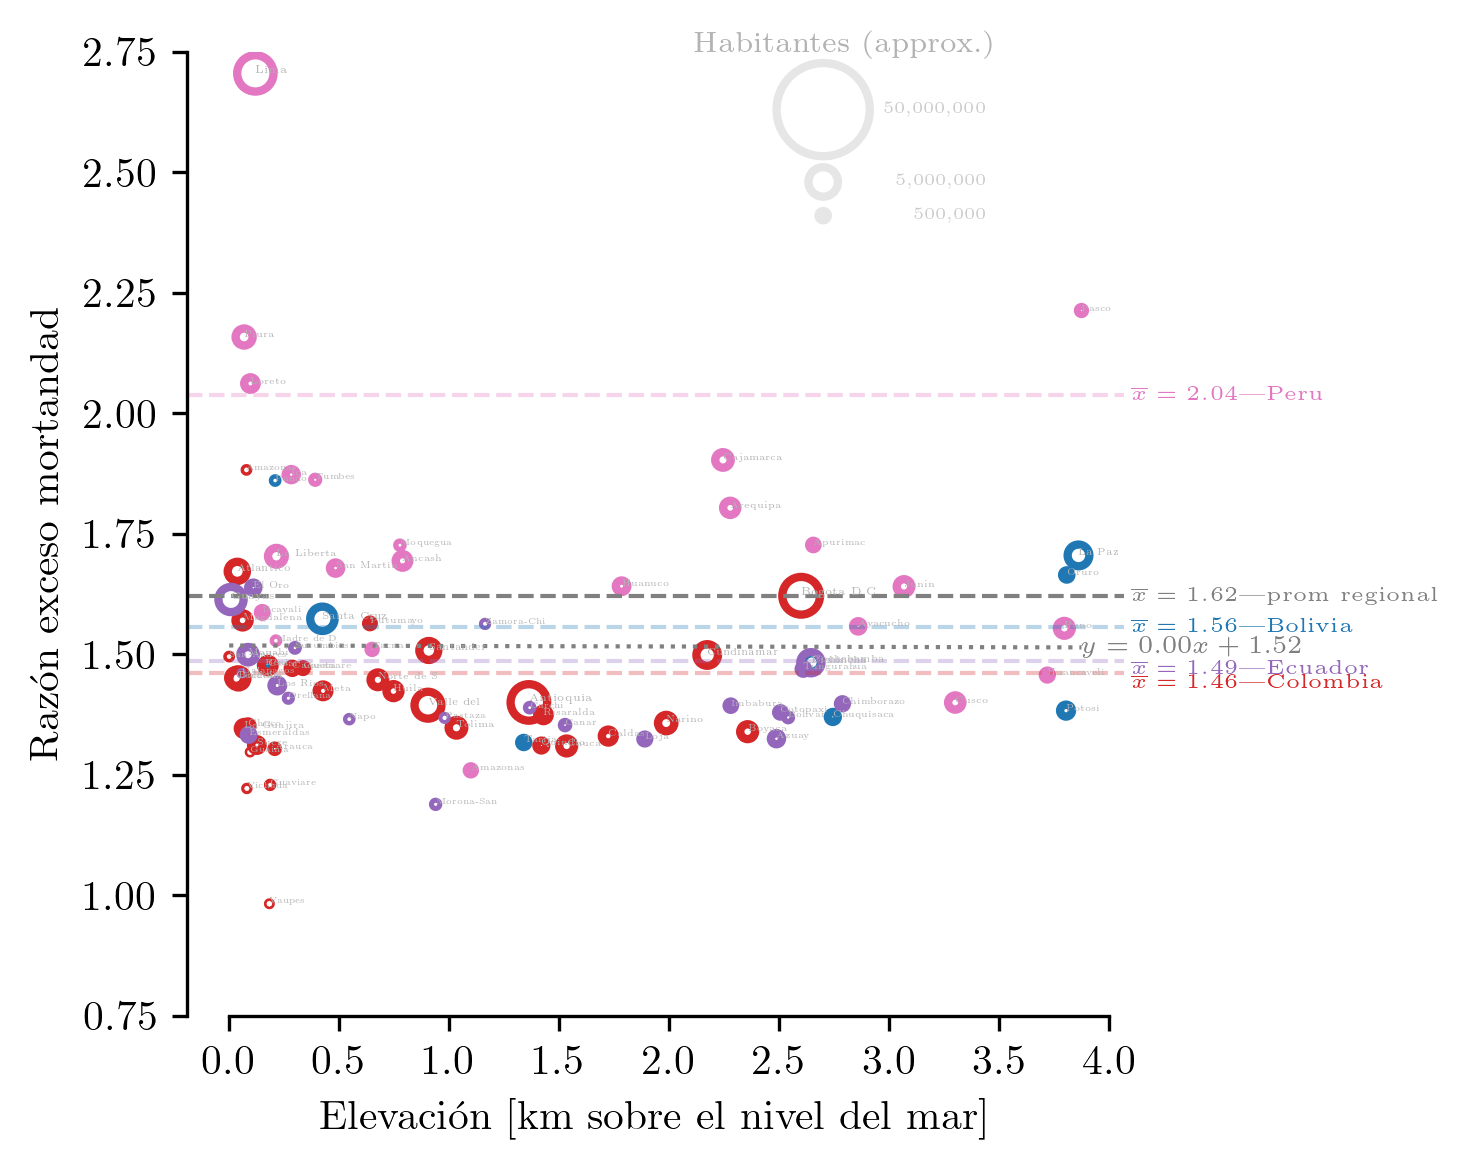

In [128]:
f,ax= plt.subplots(dpi=300,figsize=(5,4))
ax.scatter(
    f2['weighted_height'],
    f2['ratio'],
    s=f2['pop']/100000,
    edgecolors=cs,
    lw=2,
    facecolor='none'
)
ax.set_ylim(.75,2.75)
ax.axhline(wmea,c='.5',ls='--',lw=1)
ax.plot(X.values[:,0],yp13,ls=':',c='.5',lw=1)
ax.text(X.values[-1,0],yp13[-1],fy,va='center',fontsize=6,c='.5')



sns.despine(f,trim=True)
ax.set_ylabel('Razón exceso mortandad')
ax.set_xlabel('Elevación [km sobre el nivel del mar]')

# al = {0:'bottom',1:'top'}

for i,c in enumerate(dic.keys()):
    ax.axhline(wmeans[c],alpha=.3,lw=1,ls='--',c=cm(dic[c]))
#   ax.plot(*f_xy[c],ls='-.',lw=1,alpha=.5)
#   ax.text(.5,1-i/20,c,transform=ax.transAxes,c=cm(dic[c]))
    ax.text(4.1,wmeans[c]+doff[c],f'$\overline{{x}}={wmeans[c]:.2f}$|{c}',
            fontsize=5,c=cm(dic[c]),va='center')
    pass

ax.text(4.1,wmea,f'$\overline{{x}}={wmea:.2f}$|prom regional',
        fontsize=5,c='.5',va='center')

for i,r in f2.iterrows():
    ax.text(r['weighted_height'],r['ratio'],
           r['adm'][:10], fontsize = (r['pop'])**.5/5000+2,
            c='.7'
           )
xx = [2.7,2.7,2.7]
yy = [2.63,2.48,2.41]
pp = [5e7,5e6,5e5]
ax.scatter(
    xx,
    yy,
    s=np.array(pp)/100000,
    lw=2,
    facecolor='none',
    edgecolor='.9')

for x,y,p in zip(xx,yy,pp):
    ax.text(x+.75,y,f'{int(p):,}',va='center',ha='right',fontsize=4,c='.8')
    
ax.text(xx[0]+.1,2.75,'Habitantes (approx.)',fontsize=7,c='.7',ha='center')
f.tight_layout()
f.savefig('reg_alt_alt.pdf')
f.savefig('reg_alt_alt.png')